## Libraries

In [1]:
import abc
import codecs
import inspect
import json
import logging
import gc
import pickle
import sys
import time
import warnings

import catboost as cat
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from abc import abstractmethod
from contextlib import contextmanager
from pathlib import Path
from typing import List, Optional, Union, Tuple, Dict, Sequence

from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split, GroupKFold
from tqdm import tqdm_notebook

## Config

In [2]:
conf_string = '''
dataset:
  dir: "../input/data-science-bowl-2019/"
  feature_dir: "../features"
  params:

features:
  - Basic
  - PastAssessment

av:
  split_params:
    test_size: 0.33
    random_state: 42

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    first_metric_only: True

  train_params:
    num_boost_round: 1000
    early_stopping_rounds: 100
    verbose_eval: 100

model:
  name: "catboost"
  model_params:
    loss_function: "RMSE"
    task_type: "CPU"
    iterations: 6000
    early_stopping_rounds: 100
    random_seed: 42

  train_params:
    mode: "regression"

val:
  name: "group_kfold"
  params:
    n_splits: 5

output_dir: "output"
'''

In [3]:
config = dict(yaml.load(conf_string, Loader=yaml.SafeLoader))

## Functions and Classes

### utils

#### checker

In [4]:
def feature_existence_checker(feature_path: Path,
                              feature_names: List[str]) -> bool:
    features = [f.name for f in feature_path.glob("*.ftr")]
    for f in feature_names:
        if f + "_train.ftr" not in features:
            return False
        if f + "_test.ftr" not in features:
            return False
    return True

#### jsonutil

In [5]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def save_json(config: dict, save_path: Union[str, Path]):
    f = codecs.open(str(save_path), mode="w", encoding="utf-8")
    json.dump(config, f, indent=4, cls=MyEncoder, ensure_ascii=False)
    f.close()

#### logger

In [6]:
def configure_logger(config_name: str, log_dir: Union[Path, str], debug: bool):
    if isinstance(log_dir, str):
        Path(log_dir).mkdir(parents=True, exist_ok=True)
    else:
        log_dir.mkdir(parents=True, exist_ok=True)

    log_filename = config_name.split("/")[-1].replace(".yml", ".log")
    log_filepath = log_dir / log_filename \
        if isinstance(log_dir, Path) else Path(log_dir) / log_filename

    # delete the old log
    if log_filepath.exists():
        with open(log_filepath, mode="w"):
            pass

    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(
        filename=str(log_filepath),
        level=level,
        format="%(asctime)s %(levelname)s %(message)s",
        datefmt="%m/%d/%Y %I:%M:%S %p")

#### timer

In [7]:
@contextmanager
def timer(name: str, log: bool = False):
    t0 = time.time()
    msg = f"[{name}] start"
    if not log:
        print(msg)
    else:
        logging.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if not log:
        print(msg)
    else:
        logging.info(msg)

### validation

In [8]:
def group_kfold(df: pd.DataFrame, groups: pd.Series,
                config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    params = config["val"]["params"]
    kf = GroupKFold(n_splits=params["n_splits"])
    split = list(kf.split(df, groups=groups))
    return split


def get_validation(df: pd.DataFrame,
                   config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    name: str = config["val"]["name"]

    func = globals().get(name)
    if func is None:
        raise NotImplementedError

    if "group" in name:
        cols = df.columns.tolist()
        cols.remove("group")
        groups = df["group"]
        return func(df[cols], groups, config)
    else:
        return func(df, config)

### evaluation

#### metrics

In [9]:
def qwk(y_true: Union[np.ndarray, list],
        y_pred: Union[np.ndarray, list],
        max_rat: int = 3) -> float:
    y_true_ = np.asarray(y_true)
    y_pred_ = np.asarray(y_pred)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    uniq_class = np.unique(y_true_)
    for i in uniq_class:
        hist1[int(i)] = len(np.argwhere(y_true_ == i))
        hist2[int(i)] = len(np.argwhere(y_pred_ == i))

    numerator = np.square(y_true_ - y_pred_).sum()

    denominator = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            denominator += hist1[i] * hist2[j] * (i - j) * (i - j)

    denominator /= y_true_.shape[0]
    return 1 - numerator / denominator


def calc_metric(y_true: Union[np.ndarray, list],
                y_pred: Union[np.ndarray, list]) -> float:
    return qwk(y_true, y_pred)

#### optimization

In [10]:
class OptimizedRounder(object):
    def __init__(self, n_overall: int = 5, n_classwise: int = 5):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.coef = [0.25, 0.5, 0.75]

    def _loss(self, X: np.ndarray, y: np.ndarray) -> float:
        X_p = np.digitize(X, self.coef)
        ll = -calc_metric(y, X_p)
        return ll

    def fit(self, X: np.ndarray, y: np.ndarray):
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(0.01, 0.4), (0.4, 0.7), (0.7, 0.9)]
        for _ in range(self.n_overall):
            for idx in range(3):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                self.coef[idx] = a
                la = self._loss(X, y)
                self.coef[idx] = b
                lb = self._loss(X, y)
                for it in range(self.n_classwise):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        self.coef[idx] = a
                        la = self._loss(X, y)
                    else:
                        b = b - (b - a) * golden2
                        self.coef[idx] = b
                        lb = self._loss(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X_p = np.digitize(X, self.coef)
        return X_p

#### cat

In [11]:
class CatBoostOptimizedQWKMetric(object):
    def get_final_error(self, error: float, weight: float) -> float:
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target,
                 weight: Optional[Sequence[float]]) -> Tuple[float, float]:
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]
        approx_np = np.array(approx)
        target_np = (np.array(target) * 3).astype(int)

        OptR = OptimizedRounder(n_classwise=5, n_overall=5)
        OptR.fit(approx_np, target_np)

        y_pred = OptR.predict(approx_np).astype(int)
        y_true = target_np.astype(int)

        weight_sum = 1.0
        qwk = calc_metric(y_true, y_pred)
        return qwk, weight_sum

### models

#### base

In [12]:
# type alias
AoD = Union[np.ndarray, pd.DataFrame]
AoS = Union[np.ndarray, pd.Series]
CatModel = Union[cat.CatBoostClassifier, cat.CatBoostRegressor]
LGBModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]
Model = Union[CatModel, LGBModel]


class BaseModel(object):
    @abstractmethod
    def fit(self, x_train: AoD, y_train: AoS, x_valid: AoD, y_valid: AoS,
            config: dict) -> Tuple[Model, dict]:
        raise NotImplementedError

    @abstractmethod
    def get_best_iteration(self, model: Model) -> int:
        raise NotImplementedError

    @abstractmethod
    def predict(self, model: Model, features: AoD) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_feature_importance(self, model: Model) -> np.ndarray:
        raise NotImplementedError

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        return oof_preds, test_preds

    def cv(self,
           y_train: AoS,
           train_features: AoD,
           test_features: AoD,
           feature_name: List[str],
           folds_ids: List[Tuple[np.ndarray, np.ndarray]],
           config: dict,
           log: bool = True
           ) -> Tuple[List[Model], np.ndarray, np.ndarray, pd.DataFrame, dict]:
        # initialize
        test_preds = np.zeros(len(test_features))
        oof_preds = np.zeros(len(train_features))
        importances = pd.DataFrame(index=feature_name)
        best_iteration = 0.0
        cv_score_list: List[dict] = []
        models: List[Model] = []

        X = train_features.values if isinstance(train_features, pd.DataFrame) \
            else train_features
        y = y_train.values if isinstance(y_train, pd.Series) \
            else y_train

        for i_fold, (trn_idx, val_idx) in enumerate(folds_ids):
            # get train data and valid data
            x_trn = X[trn_idx]
            y_trn = y[trn_idx]
            x_val = X[val_idx]
            y_val = y[val_idx]

            # train model
            model, best_score = self.fit(x_trn, y_trn, x_val, y_val, config)
            cv_score_list.append(best_score)
            models.append(model)
            best_iteration += self.get_best_iteration(model) / len(folds_ids)

            # predict oof and test
            oof_preds[val_idx] = self.predict(model, x_val).reshape(-1)
            test_preds += self.predict(
                model, test_features).reshape(-1) / len(folds_ids)

            # get feature importances
            importances_tmp = pd.DataFrame(
                self.get_feature_importance(model),
                columns=[f"gain_{i_fold+1}"],
                index=feature_name)
            importances = importances.join(importances_tmp, how="inner")

        # summary of feature importance
        feature_importance = importances.mean(axis=1)

        # post_process (if you have any)
        oof_preds, test_preds = self.post_process(oof_preds, test_preds,
                                                  y_train)

        # print oof score
        oof_score = calc_metric(y_train, oof_preds)
        print(f"oof score: {oof_score:.5f}")

        if log:
            logging.info(f"oof score: {oof_score:.5f}")

        evals_results = {
            "evals_result": {
                "oof_score":
                oof_score,
                "cv_score": {
                    f"cv{i + 1}": cv_score
                    for i, cv_score in enumerate(cv_score_list)
                },
                "n_data":
                len(train_features),
                "best_iteration":
                best_iteration,
                "n_features":
                len(train_features.columns),
                "feature_importance":
                feature_importance.sort_values(ascending=False).to_dict()
            }
        }

        return models, oof_preds, test_preds, feature_importance, evals_results

#### cat

In [13]:
CatModel = Union[CatBoostClassifier, CatBoostRegressor]


class CatBoost(BaseModel):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            config: dict) -> Tuple[CatModel, dict]:
        model_params = config["model"]["model_params"]
        mode = config["model"]["train_params"]["mode"]
        self.mode = mode
        if mode == "regression":
            model = CatBoostRegressor(
                eval_metric=CatBoostOptimizedQWKMetric(), **model_params)
            self.denominator = y_train.max()
            y_train = y_train / y_train.max()
            y_valid = y_valid / y_valid.max()
        else:
            model = CatBoostClassifier(**model_params)

        model.fit(
            x_train,
            y_train,
            eval_set=(x_valid, y_valid),
            use_best_model=True,
            verbose=model_params["early_stopping_rounds"])
        best_score = model.best_score_
        return model, best_score

    def get_best_iteration(self, model: CatModel):
        return model.best_iteration_

    def predict(self, model: CatModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        return model.predict(features)

    def get_feature_importance(self, model: CatModel) -> np.ndarray:
        return model.feature_importances_

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        # Override
        OptR = OptimizedRounder(n_overall=20, n_classwise=20)
        OptR.fit(oof_preds, y)
        oof_preds_ = OptR.predict(oof_preds)
        test_preds_ = OptR.predict(test_preds)
        return oof_preds_, test_preds_

#### factory

In [14]:
def catboost() -> CatBoost:
    return CatBoost()


def get_model(config: dict):
    model_name = config["model"]["name"]
    func = globals().get(model_name)
    if func is None:
        raise NotImplementedError
    return func()

### features

#### base

In [15]:
class Feature(metaclass=abc.ABCMeta):
    prefix = ""
    suffix = ""
    save_dir = "features"
    is_feature = True

    def __init__(self):
        self.name = self.__class__.__name__
        self.train = pd.DataFrame()
        self.test = pd.DataFrame()
        Path(self.save_dir).mkdir(parents=True, exist_ok=True)
        self.train_path = Path(self.save_dir) / f"{self.name}_train.ftr"
        self.test_path = Path(self.save_dir) / f"{self.name}_test.ftr"

    def run(self,
            train_df: pd.DataFrame,
            test_df: Optional[pd.DataFrame] = None,
            log: bool = False):
        with timer(self.name, log=log):
            self.create_features(train_df, test_df)
            prefix = self.prefix + "_" if self.prefix else ""
            suffix = self.suffix + "_" if self.suffix else ""
            self.train.columns = [str(c) for c in self.train.columns]
            self.test.columns = [str(c) for c in self.test.columns]
            self.train.columns = prefix + self.train.columns + suffix
            self.test.columns = prefix + self.test.columns + suffix
        return self

    @abc.abstractmethod
    def create_features(self, train_df: pd.DataFrame,
                        test_df: Optional[pd.DataFrame]):
        raise NotImplementedError

    def save(self):
        self.train.to_feather(str(self.train_path))
        self.test.to_feather(str(self.test_path))


class PartialFeature(metaclass=abc.ABCMeta):
    def __init__(self):
        self.df = pd.DataFrame

    @abc.abstractmethod
    def create_features(self, df: pd.DataFrame, test: bool = False):
        raise NotImplementedError


def is_feature(klass) -> bool:
    return "is_feature" in set(dir(klass))


def get_features(namespace: dict):
    for v in namespace.values():
        if inspect.isclass(v) and is_feature(v) and not inspect.isabstract(v):
            yield v()


def generate_features(train_df: pd.DataFrame,
                      test_df: pd.DataFrame,
                      namespace: dict,
                      overwrite: bool,
                      log: bool = False):
    for f in get_features(namespace):
        if f.train_path.exists() and f.test_path.exists() and not overwrite:
            if not log:
                print(f.name, "was skipped")
            else:
                logging.info(f"{f.name} was skipped")
        else:
            f.run(train_df, test_df, log).save()


def load_features(config: dict) -> Tuple[pd.DataFrame, pd.DataFrame]:
    feather_path = config["dataset"]["feature_dir"]

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_train.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_train.ftr").exists()
    ]
    x_train = pd.concat(dfs, axis=1)

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_test.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_test.ftr").exists()
    ]
    x_test = pd.concat(dfs, axis=1)
    return x_train, x_test

#### basic

In [16]:
IoF = Union[int, float]
IoS = Union[int, str]


class Basic(Feature):
    def create_features(self, train_df: pd.DataFrame, test_df: pd.DataFrame):
        all_activities = set(train_df["title"].unique()).union(
            set(test_df["title"].unique()))
        all_event_codes = set(train_df["event_code"].unique()).union(
            test_df["event_code"].unique())
        activities_map = dict(
            zip(all_activities, np.arange(len(all_activities))))
        inverse_activities_map = dict(
            zip(np.arange(len(all_activities)), all_activities))

        compiled_data_train: List[List[IoF]] = []
        compiled_data_test: List[List[IoF]] = []

        installation_ids_train = []
        installation_ids_test = []

        train_df["title"] = train_df["title"].map(activities_map)
        test_df["title"] = test_df["title"].map(activities_map)

        train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
        test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

        for ins_id, user_sample in tqdm_notebook(
                train_df.groupby("installation_id", sort=False),
                total=train_df["installation_id"].nunique(),
                desc="train features"):
            if "Assessment" not in user_sample["type"].unique():
                continue
            feats = KernelFeatures(all_activities, all_event_codes,
                                   activities_map, inverse_activities_map)
            feat_df = feats.create_features(user_sample, test=False)
            installation_ids_train.extend([ins_id] * len(feat_df))
            compiled_data_train.append(feat_df)
        self.train = pd.concat(compiled_data_train, axis=0, sort=False)
        self.train["installation_id"] = installation_ids_train
        self.train.reset_index(drop=True, inplace=True)

        for ins_id, user_sample in tqdm_notebook(
                test_df.groupby("installation_id", sort=False),
                total=test_df["installation_id"].nunique(),
                desc="test features"):
            feats = KernelFeatures(all_activities, all_event_codes,
                                   activities_map, inverse_activities_map)
            feat_df = feats.create_features(user_sample, test=True)
            installation_ids_test.extend([ins_id] * len(feat_df))
            compiled_data_test.append(feat_df)
        self.test = pd.concat(compiled_data_test, axis=0, sort=False)
        self.test["installation_id"] = installation_ids_test
        self.test.reset_index(drop=True, inplace=True)


class KernelFeatures(PartialFeature):
    def __init__(self, all_activities: set, all_event_codes: set,
                 activities_map: Dict[str, float],
                 inverse_activities_map: Dict[float, str]):
        self.all_activities = all_activities
        self.all_event_codes = all_event_codes
        self.activities_map = activities_map
        self.inverse_activities_map = inverse_activities_map

        win_code = dict(
            zip(activities_map.values(),
                (4100 * np.ones(len(activities_map))).astype(int)))
        win_code[activities_map["Bird Measurer (Assessment)"]] = 4110
        self.win_code = win_code

        super().__init__()

    def create_features(self, df: pd.DataFrame, test: bool = False):
        time_spent_each_act = {act: 0 for act in self.all_activities}
        event_code_count = {ev: 0 for ev in self.all_event_codes}
        user_activities_count: Dict[IoS, IoF] = {
            "Clip": 0,
            "Activity": 0,
            "Assessment": 0,
            "Game": 0
        }

        all_assesments = []

        accumulated_acc_groups = 0
        accumulated_acc = 0
        accumulated_correct_attempts = 0
        accumulated_failed_attempts = 0
        accumulated_actions = 0

        counter = 0

        accuracy_group: Dict[int, int] = {0: 0, 1: 0, 2: 0, 3: 0}

        durations: List[float] = []
        last_activity = ""

        for i, sess in df.groupby("game_session", sort=False):
            sess_type = sess["type"].iloc[0]
            sess_title = sess["title"].iloc[0]

            if sess_type != "Assessment":
                time_spent = int(sess["game_time"].iloc[-1] / 1000)
                time_spent_each_act[
                    self.inverse_activities_map[sess_title]] += time_spent

            if sess_type == "Assessment" and (test or len(sess) > 1):
                all_attempts: pd.DataFrame = sess.query(
                    f"event_code == {self.win_code[sess_title]}")
                true_attempt = all_attempts["event_data"].str.contains(
                    "true").sum()
                false_attempt = all_attempts["event_data"].str.contains(
                    "false").sum()

                features = user_activities_count.copy()
                features.update(time_spent_each_act.copy())
                features.update(event_code_count.copy())

                features["session_title"] = sess_title

                features["accumulated_correct_attempts"] = \
                    accumulated_correct_attempts
                features["accumulated_failed_attempts"] = \
                    accumulated_failed_attempts

                accumulated_correct_attempts += true_attempt
                accumulated_failed_attempts += false_attempt

                features["duration_mean"] = np.mean(
                    durations) if durations else 0
                durations.append((sess.iloc[-1, 2] - sess.iloc[0, 2]).seconds)

                features["accumulated_acc"] = \
                    accumulated_acc / counter if counter > 0 else 0

                acc = true_attempt / (true_attempt + false_attempt) \
                    if (true_attempt + false_attempt) != 0 else 0
                accumulated_acc += acc

                if acc == 0:
                    features["accuracy_group"] = 0
                elif acc == 1:
                    features["accuracy_group"] = 3
                elif acc == 0.5:
                    features["accuracy_group"] = 2
                else:
                    features["accuracy_group"] = 1

                features.update(accuracy_group.copy())
                accuracy_group[features["accuracy_group"]] += 1

                features["accumulated_accuracy_group"] = \
                    accumulated_acc_groups / counter if counter > 0 else 0
                accumulated_acc_groups += features["accuracy_group"]

                features["accumulated_actions"] = accumulated_actions

                if test:
                    all_assesments.append(features)
                elif true_attempt + false_attempt > 0:
                    all_assesments.append(features)

                counter += 1

            num_event_codes: dict = sess["event_code"].value_counts().to_dict()
            for k in num_event_codes.keys():
                event_code_count[k] += num_event_codes[k]

            accumulated_actions += len(sess)
            if last_activity != sess_type:
                user_activities_count[sess_type] + +1
                last_activity = sess_type

        if test:
            self.df = pd.DataFrame([all_assesments[-1]])
        else:
            self.df = pd.DataFrame(all_assesments)

        return self.df

#### past_assessment

In [17]:
IoF = Union[int, float]


class PastAssessment(Feature):
    def create_features(self, train_df: pd.DataFrame, test_df: pd.DataFrame):
        train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
        test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

        compiled_data_train: List[pd.DataFrame] = []
        compiled_data_test: List[pd.DataFrame] = []

        for ins_id, user_sample in tqdm_notebook(
                train_df.groupby("installation_id", sort=False),
                total=train_df["installation_id"].nunique(),
                desc="train past assessment"):
            if "Assessment" not in user_sample["type"].unique():
                continue
            feat_df = past_assess_features(user_sample, test=False)

            compiled_data_train.append(feat_df)
        self.train = pd.concat(compiled_data_train, axis=0, sort=False)
        self.train.reset_index(drop=True, inplace=True)

        for ins_id, user_sample in tqdm_notebook(
                test_df.groupby("installation_id", sort=False),
                total=test_df["installation_id"].nunique(),
                desc="test past assessment"):
            feat_df = past_assess_features(user_sample, test=True)
            compiled_data_test.append(feat_df)
        self.test = pd.concat(compiled_data_test, axis=0, sort=False)
        self.test.reset_index(drop=True, inplace=True)


def past_assess_features(user_sample: pd.DataFrame,
                         test: bool = False) -> pd.DataFrame:
    all_assesments = []
    for sess_id, sess in user_sample.groupby("game_session", sort=False):
        if sess["type"].iloc[0] != "Assessment":
            continue

        if sess["type"].iloc[0] == "Assessment" and (test or len(sess) > 1):
            features: Dict[str, IoF] = {}
            # only Assessment session will be go through here after
            sess_start_idx: int = sess.index.min()
            sess_title: str = sess.title.iloc[0]
            history: pd.DataFrame = user_sample.loc[:sess_start_idx - 1, :]

            features["has_same_assessment_in_past"] = \
                int(sess_title in history["title"].unique())
            features["n_same_assessment_in_past"] = \
                history.query(
                    f"title == '{sess_title}'"
                )["game_session"].nunique()

            dur_from_last_assessment = np.iinfo(np.int).max
            if "Assessment" in history["type"].unique():
                delta = (sess.timestamp.min() -
                         history.query("type == 'Assessment'").timestamp.max())
                dur_from_last_assessment = delta.seconds
            features["memory_decay_coeff_from_last_assess"] = np.exp(
                -dur_from_last_assessment / 86400)

            dur_from_last_assessment = np.iinfo(np.int).max
            if features["has_same_assessment_in_past"] == 1:
                delta = (
                    sess.timestamp.min() -
                    history.query(f"title == '{sess_title}'").timestamp.max())
                dur_from_last_assessment = delta.seconds
            features["memory_decay_coeff_from_last_same_assess"] = np.exp(
                -dur_from_last_assessment / 86400)

            # work on the same assessments
            if features["has_same_assessment_in_past"] == 1:
                same_assessments = history.query(f"title == '{sess_title}'")
                attempt_code = 4110 if (
                    sess_title == "Bird Measurer (Assessment)") else 4100
                all_attempts = same_assessments.query(
                    f"event_code == {attempt_code}")
                succ_attempts = all_attempts["event_data"].str.contains(
                    "true").sum()
                fail_attempts = all_attempts["event_data"].str.contains(
                    "false").sum()
                features["n_success_same_assess"] = succ_attempts
                features["n_failure_same_assess"] = fail_attempts
                features["success_ratio_same_assess"] = succ_attempts / len(
                    all_attempts) if len(all_attempts) != 0 else 0

                # work on the last same assessment
                sess_id_last_same_assess = same_assessments[
                    "game_session"].unique()[-1]
                last_same_assess = history.query(
                    f"game_session == '{sess_id_last_same_assess}'")
                all_attempts = last_same_assess.query(
                    f"event_code == {attempt_code}")
                succ_attempts = all_attempts["event_data"].str.contains(
                    "true").sum()
                fail_attempts = all_attempts["event_data"].str.contains(
                    "false").sum()
                features["n_success_last_same_assess"] = succ_attempts
                features["n_failure_last_same_assess"] = fail_attempts
                acc = succ_attempts / len(all_attempts) \
                    if len(all_attempts) != 0 else 0
                features["success_ratio_last_same_assess"] = acc
                if acc == 0:
                    features["last_same_accuracy_group"] = 0
                elif acc == 1:
                    features["last_same_accuracy_group"] = 3
                elif acc == 0.5:
                    features["last_same_accuracy_group"] = 2
                else:
                    features["last_same_accuracy_group"] = 1
            else:
                features["n_success_same_assess"] = -1
                features["n_failure_same_assess"] = -1
                features["success_ratio_same_assess"] = -1
                features["n_success_last_same_assess"] = -1
                features["n_failure_last_same_assess"] = -1
                features["success_ratio_last_same_assess"] = -1
                features["last_same_accuracy_group"] = -1
            for col in [
                    "last_same_accuracy_group", "n_failure_last_same_assess",
                    "n_success_last_same_assess",
                    "success_ratio_last_same_assess"
            ]:
                features["decayed_" + col] = features[col] * features[
                    "memory_decay_coeff_from_last_same_assess"]

            attempt_code = 4110 if (
                sess_title == "Bird Measurer (Assessment)") else 4100
            all_attempts: pd.DataFrame = sess.query(
                f"event_code == {attempt_code}")
            if test:
                all_assesments.append(features)
            elif len(all_attempts) > 0:
                all_assesments.append(features)

    if test:
        all_assess_df = pd.DataFrame([all_assesments[-1]])
    else:
        all_assess_df = pd.DataFrame(all_assesments)
    return all_assess_df

## main

### Settings

In [18]:
warnings.filterwarnings("ignore")

# argsの代わり
debug = True
config_path = "../config/cat_0.yml"
log_dir = "../log/"

configure_logger(config_path, log_dir, debug)

logging.info(f"config: {config_path}")
logging.info(f"debug: {debug}")

config["args"] = dict()
config["args"]["config"] = config_path

# make output dir
output_root_dir = Path(config["output_dir"])
feature_dir = Path(config["dataset"]["feature_dir"])

config_name: str = config_path.split("/")[-1].replace(".yml", "")
output_dir = output_root_dir / config_name
output_dir.mkdir(parents=True, exist_ok=True)

logging.info(f"model output dir: {str(output_dir)}")

config["model_output_dir"] = str(output_dir)

### Data/Feature Loading

In [24]:
input_dir = Path(config["dataset"]["dir"])

if not feature_existence_checker(feature_dir, config["features"]):
    with timer(name="load data", log=True):
        train = pd.read_csv(input_dir / "train.csv")
        test = pd.read_csv(input_dir / "test.csv")
        specs = pd.read_csv(input_dir / "specs.csv")
        
    generate_features(
        train, test, namespace=globals(), overwrite=False, log=True)

    del train, test
    gc.collect()

with timer("feature laoding", log=True):
    x_train = pd.concat([
        pd.read_feather(feature_dir / (f + "_train.ftr"), nthreads=-1)
        for f in config["features"]
    ],
                        axis=1,
                        sort=False)
    x_test = pd.concat([
        pd.read_feather(feature_dir / (f + "_test.ftr"), nthreads=-1)
        for f in config["features"]
    ],
                        axis=1,
                        sort=False)

groups = x_train["installation_id"].values
y_train = x_train["accuracy_group"].values.reshape(-1)
cols: List[str] = x_train.columns.tolist()
cols.remove("installation_id")
cols.remove("accuracy_group")
x_train, x_test = x_train[cols], x_test[cols]

assert len(x_train) == len(y_train)
logging.debug(f"number of features: {len(cols)}")
logging.debug(f"number of train samples: {len(x_train)}")
logging.debug(f"numbber of test samples: {len(x_test)}")

### Adversarial Validation

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.793127	valid's auc: 0.705439
[200]	train's auc: 0.838972	valid's auc: 0.707636
[300]	train's auc: 0.866018	valid's auc: 0.709377
[400]	train's auc: 0.891329	valid's auc: 0.708394
Early stopping, best iteration is:
[346]	train's auc: 0.879647	valid's auc: 0.711987
Evaluated only: auc


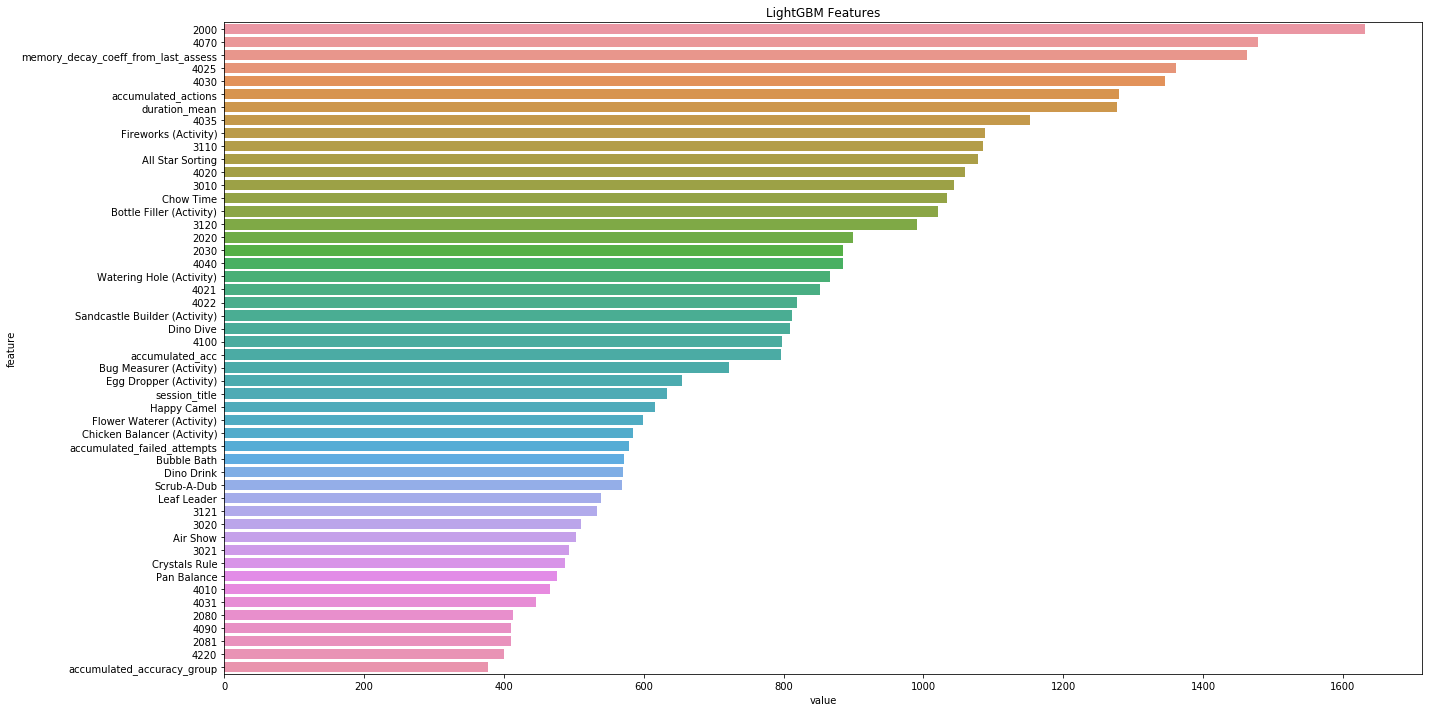

In [26]:
logging.info("Adversarial Validation")
train_adv = x_train.copy()
test_adv = x_test.copy()

train_adv["target"] = 0
test_adv["target"] = 1
train_test_adv = pd.concat([train_adv, test_adv], axis=0,
                           sort=False).reset_index(drop=True)

split_params: dict = config["av"]["split_params"]
train_set, val_set = train_test_split(
    train_test_adv,
    random_state=split_params["random_state"],
    test_size=split_params["test_size"])
x_train_adv = train_set[cols]
y_train_adv = train_set["target"]
x_val_adv = val_set[cols]
y_val_adv = val_set["target"]

logging.debug(f"The number of train set: {len(x_train_adv)}")
logging.debug(f"The number of valid set: {len(x_val_adv)}")

train_lgb = lgb.Dataset(x_train_adv, label=y_train_adv)
valid_lgb = lgb.Dataset(x_val_adv, label=y_val_adv)

model_params = config["av"]["model_params"]
train_params = config["av"]["train_params"]
clf = lgb.train(
    model_params,
    train_lgb,
    valid_sets=[train_lgb, valid_lgb],
    valid_names=["train", "valid"],
    **train_params)

# Check the feature importance
feature_imp = pd.DataFrame(
    sorted(zip(clf.feature_importance(importance_type="gain"), cols)),
    columns=["value", "feature"])

plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("LightGBM Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_adv.png")

config["av_result"] = dict()
config["av_result"]["score"] = clf.best_score
config["av_result"]["feature_importances"] = \
    feature_imp.set_index("feature").sort_values(
        by="value",
        ascending=False
    ).head(100).to_dict()["value"]

### Train model

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 278ms	remaining: 27m 50s
100:	learn: 0.5553617	test: 0.5680877	best: 0.5680877 (100)	total: 20.6s	remaining: 20m 1s
200:	learn: 0.5940563	test: 0.5953988	best: 0.5959324 (189)	total: 44.4s	remaining: 21m 21s
300:	learn: 0.6043054	test: 0.6044892	best: 0.6052004 (274)	total: 1m 5s	remaining: 20m 44s
400:	learn: 0.6136380	test: 0.6067360	best: 0.6101601 (381)	total: 1m 26s	remaining: 20m 4s
500:	learn: 0.6217138	test: 0.6100412	best: 0.6110308 (475)	total: 1m 47s	remaining: 19m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6110308302
bestIteration = 475

Shrink model to first 476 iterations.
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 196ms	remaining: 19m 37s
100:	learn: 0.5534390	test: 0.5557478	best: 0.5557478 (100)	total: 21.3s	remaining: 20m 45s
200:	learn: 0.5938018	test: 0.5996434	best: 0.6015957 (187)	total: 45.8s	remaining: 22m 2s
300:	learn: 0.6069638	test: 0.6061640	best

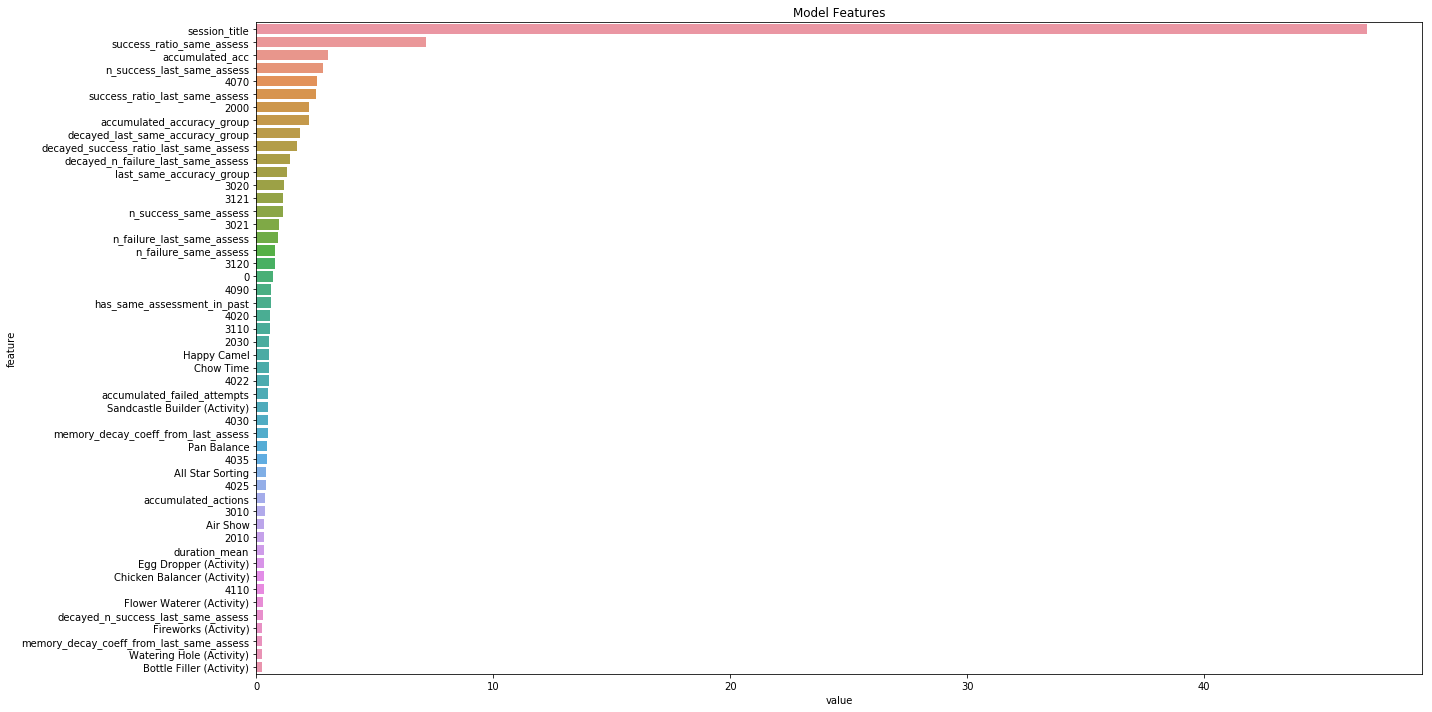

In [27]:
logging.info("Train model")

# get folds
x_train["group"] = groups
splits = get_validation(x_train, config)
x_train.drop("group", axis=1, inplace=True)

model = get_model(config)
models, oof_preds, test_preds, feature_importance, eval_results = model.cv(
    y_train, x_train, x_test, cols, splits, config, log=True)

config["eval_results"] = dict()
for k, v in eval_results.items():
    config["eval_results"][k] = v

feature_imp = feature_importance.reset_index().rename(columns={
    "index": "feature",
    0: "value"
})
plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("Model Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_model.png")

### Save

In [28]:
save_path = output_dir / "output.json"
save_json(config, save_path)
np.save(output_dir / "oof_preds.npy", oof_preds)

with open(output_dir / "model.pkl", "wb") as m:
    pickle.dump(models, m)

### Make submission

In [29]:
sample_submission = pd.read_csv(
    input_dir / "sample_submission.csv")
sample_submission["accuracy_group"] = np.round(test_preds).astype('int')
sample_submission.to_csv('submission.csv', index=None)
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,2
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,2
